In [1]:
import pandas as pd
import numpy as np
import anndata
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import scanpy as sc
import pyranges as pr

In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'figure.facecolor': 'white'})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

matplotlib.rcParams['ytick.labelright'] = False
matplotlib.rcParams['ytick.labelleft'] = True
matplotlib.rcParams['ytick.right'] = False

In [4]:
%cd ~/workspace/proj/2025/longsc

/home/elly924/workspace/proj/2025/longsc


In [5]:
import sys
sys.path.append('./src/')

In [6]:
import Splicella as spc

In [7]:
RCC1_fc = anndata.read_h5ad('data/RCC1/RCC1_fc.adata.h5ad') #made frome featurecount (gene count)

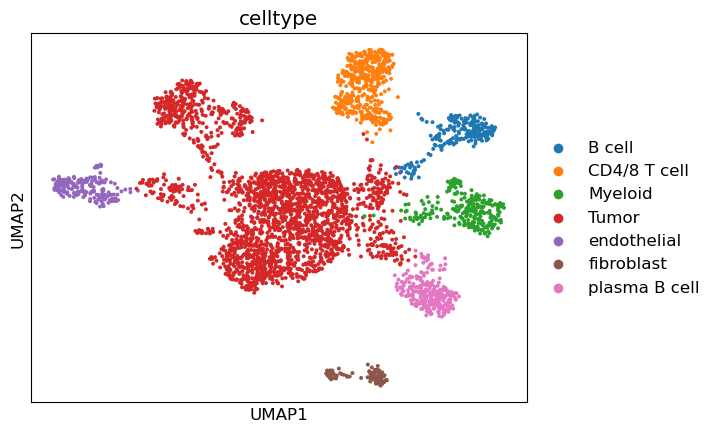

In [8]:
sc.pl.umap(RCC1_fc, color='celltype')

In [9]:
RCC1_fc_ = RCC1_fc.copy()
RCC1_fc_.var = RCC1_fc_.var.reset_index()
RCC1_fc_.var_names = np.array(RCC1_fc_.var['gene_name'])
RCC1_fc_.var_names_make_unique()

In [10]:
anno_tr = spc.utils.get_annotr_fromgtf('refs/gencode.v48.primary_assembly.annotation.gtf.gz')

In [11]:
RCC1_iso_ad = spc.utils.get_adata_from_iso(
    'data/RCC1/scNanoGPS/00_merged.curated.minimap2.transcript_grouped_counts.tsv',
    anno_tr=anno_tr)

In [12]:
RCC1_iso_ad.shape

(3710, 153887)

In [13]:
RCC1_iso_ad.write_h5ad('data/RCC1/RCC1_iso.adata.h5ad')

In [10]:
RCC1_iso_ad = anndata.read_h5ad('data/RCC1/RCC1_iso.adata.h5ad')

In [13]:
RCC1_iso_ad.shape

(3710, 153887)

In [14]:
RCC1_iso_ad_ = spc.utils.filter_isoad(RCC1_iso_ad,
                                      RCC1_fc_,
                                      obs_copy=['celltype'],
                                      uns_copy=['celltype_colors',
                                                'neighbors', 'pca', 'umap'],)

/home/elly924/workspace/proj/2025/longsc/./src/Splicella/utils.py:63: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  iso_ad_.obs[obs] = gene_ad_.obs[obs]


In [15]:
RCC1_iso_ad_.shape

(3710, 122970)

In [16]:
sc.pp.calculate_qc_metrics(RCC1_iso_ad_, inplace=True)
sc.pp.filter_genes(RCC1_iso_ad_, min_cells=3)
sc.pp.calculate_qc_metrics(RCC1_iso_ad_, inplace=True)
sc.pp.filter_cells(RCC1_iso_ad_, min_genes=20)

In [17]:
RCC1_iso_ad_.shape

(3669, 19032)

In [18]:
spcDCI = spc.SplicellaDCI_pairwise(RCC1_iso_ad_)

In [19]:
spcDCI.splicelladci() #get isoform prevalance df and do DCI test

In [20]:
spcDCI.get_dcidf() #get filtered out DCI genes

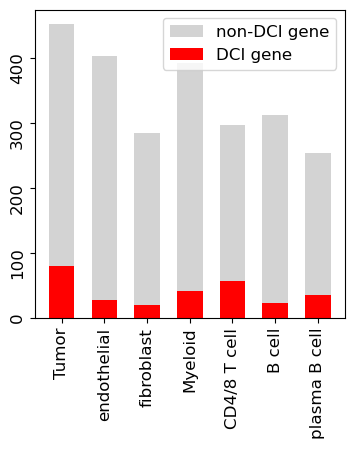

In [22]:
def get_DCIgene_barplot(spcDCI,
                       states_plot=None,
                       ax=None):
    if states_plot is None:
        states_plot = spcDCI.states
        
    DCI_df = spcDCI.DCI_df
    chitest_df = spcDCI.chitest_df
    
    total_genes = []
    for state in states_plot:
        total_genes.append(
            len(np.unique(chitest_df[chitest_df['state']==state]['gene'])))
    
    DCI_gene_counts = []
    for state in states_plot:
        DCI_gene_counts.append(len(np.unique(DCI_df[DCI_df['state']==state]['gene'])))
        
    fig, ax = plt.subplots(1,1, figsize=(4,4))
    ax.bar(x=states_plot, height=total_genes, color='lightgrey', 
           width=.6, label='non-DCI gene')
    ax.bar(x=states_plot, height=DCI_gene_counts, 
           color=['red'], width=.6, label='DCI gene')
    ax.tick_params(rotation=90)
    ax.legend()
get_DCIgene_barplot(spcDCI,
                   states_plot=['Tumor', 'endothelial', 'fibroblast',
                                'Myeloid', 'CD4/8 T cell', 
                                'B cell', 'plasma B cell'])